In [3]:
import numpy as np
import os, torch
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from multiprocessing import Pool
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import pandas as pd
from methods.low_level_attributes.image_measures import compute_brightness, compute_saturation, compute_warmth, compute_entropy
from datasets.nsd.nsd_clip import NSDCLIPFeaturesDataset
from datasets.nsd.nsd import NaturalScenesDataset
from methods.high_level_attributes.shift_vectors import load_shift_vector
from sklearn.linear_model import LinearRegression

data_dir = 'data/'
output_dir = 'data/part1_outputs'

subjects = [1,2,3,4,5,6,7,8]
hemispheres = ['left', 'right']
rois = ['OFA', 'FFA-1', 'FFA-2', 'EBA', 'FBA-1', 'FBA-2', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA-1', 'VWFA-2']

measurements = \
    [f'brightness_{i+1}' for i in range(25)] + \
    [f'saturation_{i+1}' for i in range(25)] + \
    [f'warmth_{i+1}' for i in range(25)] + \
    [f'entropy_{i+1}' for i in range(25)] + \
    [f'depth_{i+1}' for i in range(25)] + \
    [f'gaussian_curvature_{i+1}' for i in range(25)] + \
    [f'surface_normal_1_{i+1}' for i in range(25)] + \
    [f'surface_normal_2_{i+1}' for i in range(25)] + \
    [f'surface_normal_3_{i+1}' for i in range(25)]

missing = [
    (1, 'FFA-2', 'left'),
    (1, 'FBA-2', 'left'),
    (2, 'FBA-1', 'right'),
    (2, 'FBA-1', 'left'),
    (3, 'VWFA-2', 'right'),
    (4, 'VWFA-2', 'right'),
    (4, 'FBA-1', 'left'),
    (7, 'FBA-1', 'left'),
    (7, 'FBA-1', 'right'),
    (8, 'VWFA-2', 'right'),
]

colors = {
    'OFA': '#050C9C',
    'FFA-1': '#3572EF',
    'FFA-2': '#3ABEF9',
    'EBA': '#FF3EA5',
    'FBA-1': '#FF7ED4',
    'FBA-2': '#FFB5DA',
    'OPA': '#FF6500',
    'PPA': '#FF8A08',
    'RSC': '#FFC100',
    'OWFA': '#294B29',
    'VWFA-1': '#50623A',
    'VWFA-2': '#789461',
}

with open('data/laion_nouns.txt', 'r') as file:
    lines = file.readlines()
    nouns = [line.strip() for line in lines]

dimensions = pd.read_csv('data/dimensions.csv')
dimensions = dimensions['dimension'].values

# with open('data/things_66.txt', 'r') as file:
#     lines = file.readlines()
#     dimensions = [line.strip() for line in lines]
# dimensions_csv = pd.read_csv('data/laion_nouns_classification.csv')

## Gather predictions

### DINO-ViT Predictions

In [4]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_hemispheres, n_rois, n_variations)

def load_subject(subject):

    data = np.empty((2, 12, 50, 2, 12, 11))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):
                for h_i, h in enumerate(hemispheres):
                    for r_i, r in enumerate(rois):

                        preds = np.load(os.path.join(folder, subfolder, f'dino_vit_preds_{roi}_{h}.npy'))
                        if (subject, r, h) in missing:
                            preds = np.nan
                        data[hemisphere_i, roi_i, subfolder_i, h_i, r_i] = preds

    return data

f = os.path.join(output_dir, 'dino_vit_preds.npy')
if not os.path.exists(f):
    with Pool(8) as p:
        preds_dino = p.map(load_subject, subjects)
    preds_dino = np.stack(preds_dino)
    np.save(f, preds_dino)
else:
    preds_dino = np.load(f).astype(np.float32)
    print(preds_dino.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'data/part1_outputs/4_VWFA-2_left/0000/dino_vit_preds_VWFA-2_left.npy'

### CLIP Predictions

In [3]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_variations)

def load_subject(subject):

    data = np.empty((2, 12, 50, 11))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                preds = np.load(os.path.join(folder, subfolder, 'clip_linear_preds.npy'))
                data[hemisphere_i, roi_i, subfolder_i] = preds

    return data

f = os.path.join(output_dir, 'clip_linear_preds.npy')
if not os.path.exists(f):
    with Pool(8) as p:
        preds_clip = p.map(load_subject, subjects)
    preds_clip = np.stack(preds_clip)
    np.save(f, preds_clip)
else:
    preds_clip = np.load(f).astype(np.float32)
    print(preds_clip.shape)

(8, 2, 12, 50, 11)


## Gather properties

### Low-level properties

In [4]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_variations, num_measurements)

def resize(measure):
    measure = torch.from_numpy(measure).float().unsqueeze(0)
    measure = torch.nn.functional.interpolate(
        measure,
        size=(5,5),
        mode="bilinear",
        align_corners=False,
    ).squeeze(0)
    measure = measure.numpy()
    return measure

def load_subject(subject):

    data = np.empty((2, 12, 50, 11, len(measurements)))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                img_list = np.array([f for f in os.listdir(os.path.join(folder, subfolder)) if f.endswith('.png')])
                img_list_order = np.argsort([int(f.replace('.png', '')) for f in img_list])
                img_list = [os.path.join(folder, subfolder, f) for f in img_list[img_list_order]]

                for img_i, img_f in enumerate(img_list):

                    ms = []
                    
                    img = Image.open(img_f).convert("RGB")

                    # brightness
                    m = compute_brightness(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # saturation
                    m = compute_saturation(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # warmth
                    m = compute_warmth(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # entropy
                    m = compute_entropy(img)
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # depth
                    m = np.load(img_f.replace('.png', '_depth.npy'))
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # gaussian curvature
                    m = np.load(img_f.replace('.png', '_gaussian_curvature.npy'))
                    m = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m)

                    # surface normal
                    m = np.load(img_f.replace('.png', '_surface_normal.npy'))
                    m_ = resize(m)[0].reshape(-1).tolist()
                    ms.extend(m_)
                    m_ = resize(m)[1].reshape(-1).tolist()
                    ms.extend(m_)
                    m_ = resize(m)[2].reshape(-1).tolist()
                    ms.extend(m_)

                    data[hemisphere_i, roi_i, subfolder_i, img_i] = ms

    return data

f = os.path.join(output_dir, 'measurements.npy')
if not os.path.exists(f):
    with Pool(8) as p:
        measurements = p.map(load_subject, subjects)
    measurements = np.stack(measurements)
    np.save(f, measurements)
else:
    measurements = np.load(f).astype(np.float32)
    print(measurements.shape)

(8, 2, 12, 50, 11, 225)


### CLIP features

In [5]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_variations, 1024)

def load_subject(subject):

    data = np.empty((2, 12, 50, 11, 1024))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                feats = np.load(os.path.join(folder, subfolder, 'clip_feats.npy'))
                data[hemisphere_i, roi_i, subfolder_i] = feats

    return data

f = os.path.join(output_dir, 'clip_feats.npy')
if not os.path.exists(f):
    with Pool(8) as p:
        clip = p.map(load_subject, subjects)
    clip = np.stack(clip)
    np.save(f, clip)
else:
    clip = np.load(f).astype(np.float32)
    print(clip.shape)

(8, 2, 12, 50, 11, 1024)


### Noun similarities

In [6]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_variations, num_nouns)

def load_subject(subject):

    noun_vecs = np.array([np.load(os.path.join(data_dir, f'shift_vectors/nouns/{n}.npy')) for n in nouns])

    data = np.empty((2, 12, 50, 11, len(nouns)))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                feats = np.load(os.path.join(folder, subfolder, 'clip_feats.npy'))
                sim = 1 - pairwise_distances(feats, noun_vecs, metric='cosine')
                data[hemisphere_i, roi_i, subfolder_i] = sim

    return data

f = os.path.join(output_dir, 'noun_sims.npy')
if not os.path.exists(f):
    noun_sims = []
    for subject in tqdm(subjects):
        noun_sims.append(load_subject(subject))
    noun_sims = np.stack(noun_sims)
    np.save(f, noun_sims)
else:
    noun_sims = np.load(f).astype(np.float32)
    print(noun_sims.shape)

(8, 2, 12, 50, 11, 6725)


### Dimension similarities

In [122]:
# shape = (n_subjects, n_hemispheres_orig, n_rois_orig, n_source_images, n_variations, num_nouns)

def load_subject(subject):

    dim_vecs = np.array([np.load(os.path.join(data_dir, f'shift_vectors/dimensions/{d}.npy')) for d in dimensions])

    data = np.empty((2, 12, 50, 11, len(dimensions)))

    for hemisphere_i, hemisphere in enumerate(hemispheres):
        for roi_i, roi in enumerate(rois):

            folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
            if not os.path.exists(folder):
                data[hemisphere_i, roi_i] = np.nan
                continue
            subfolders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])

            for subfolder_i, subfolder in enumerate(subfolders):

                feats = np.load(os.path.join(folder, subfolder, 'clip_feats.npy'))
                sim = 1 - pairwise_distances(feats, dim_vecs, metric='cosine')
                data[hemisphere_i, roi_i, subfolder_i] = sim

    return data

f = os.path.join(output_dir, 'dimension_sims.npy')
if not os.path.exists(f):
    dimension_sims = []
    for subject in tqdm(subjects):
        dimension_sims.append(load_subject(subject))
    dimension_sims = np.stack(dimension_sims)
    np.save(f, dimension_sims)
else:
    dimension_sims = np.load(f).astype(np.float32)
    print(dimension_sims.shape)

(8, 2, 12, 50, 11, 35)


## Plots

### Visualize manipulation

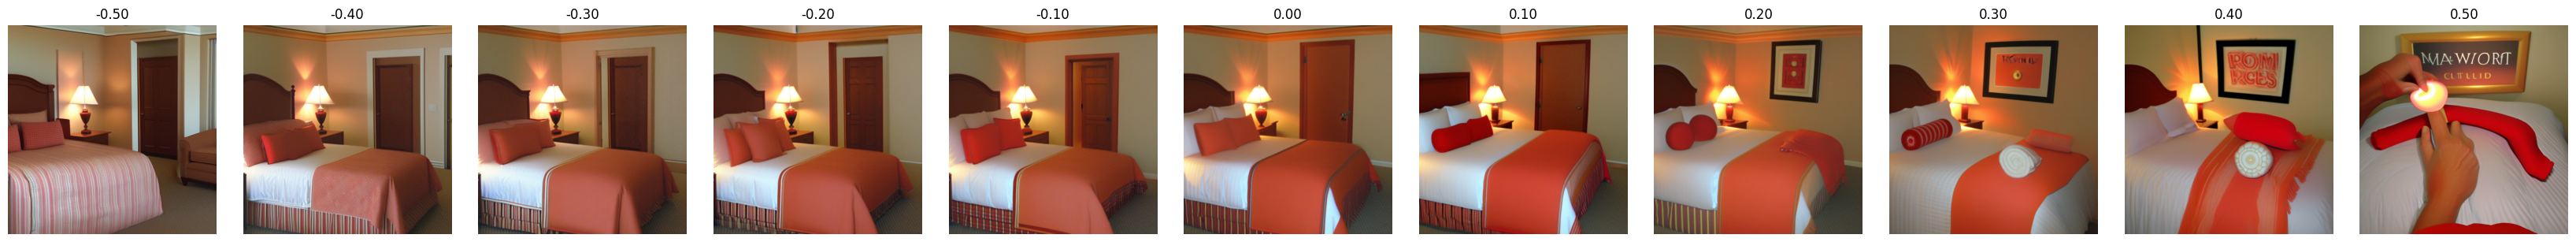

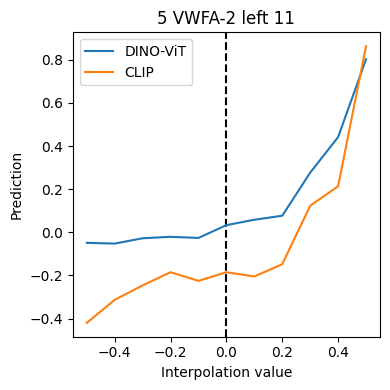

In [85]:
subject = 5
roi = 'VWFA-2'
hemisphere = 'left'

subject_i = subjects.index(subject)
roi_i = rois.index(roi)
hemisphere_i = hemispheres.index(hemisphere)

idx = np.random.choice(range(50), 1)[0]
x_range = np.linspace(-0.5, 0.5, 11)

folder = os.path.join(output_dir, f'{subject}_{roi}_{hemisphere}')
subfolder = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])[idx]

img_list = np.array([f for f in os.listdir(os.path.join(folder, subfolder)) if f.endswith('.png')])
img_list_order = np.argsort([int(f.replace('.png', '')) for f in img_list])
img_list = [os.path.join(folder, subfolder, f) for f in img_list[img_list_order]]

dino_p = preds_dino[subject_i, hemisphere_i, roi_i, idx, hemisphere_i, roi_i]
clip_p = preds_clip[subject_i, hemisphere_i, roi_i, idx]

f, axes = plt.subplots(1, 11, figsize=(33, 3))
for i, img_f in enumerate(img_list):
    img = Image.open(img_f)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'{x_range[i]:.2f}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 4))
plt.title(f'{subject} {roi} {hemisphere} {idx}')
plt.axvline(0, color='black', linestyle='--')
plt.plot(x_range, dino_p, label='DINO-ViT')
plt.plot(x_range, clip_p, label='CLIP')
plt.xlabel('Interpolation value')
plt.ylabel('Prediction')
plt.legend()
plt.tight_layout()
plt.show()

### Effect on predicted responses

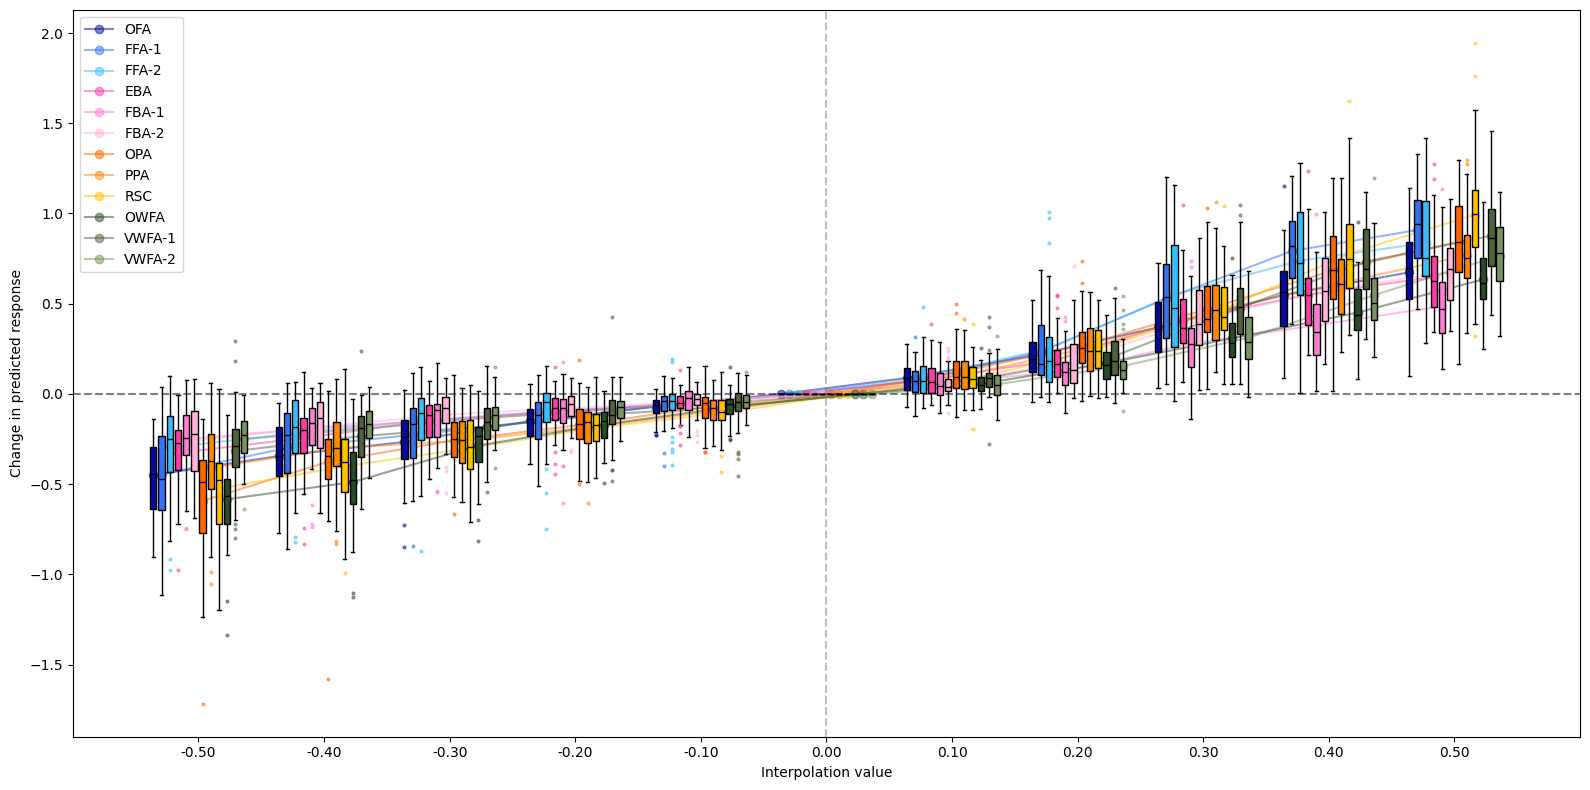

In [59]:
subject = 5
hemisphere = 'left'

subject_i = subjects.index(subject)
hemisphere_i = hemispheres.index(hemisphere)

plt.figure(figsize=(16, 8))
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)

shifts = np.linspace(-6, 6, 12) * 1.2
alphas = np.linspace(-100, 100, 11)

for roi_i, roi in enumerate(rois):

    dino_p = preds_dino[subject_i, hemisphere_i, roi_i, :, hemisphere_i, roi_i]
    dino_p = dino_p - dino_p[:, [5]]

    color = colors[roi]

    plt.plot(alphas+shifts[roi_i], dino_p.mean(axis=0), '-o', label=roi, color=color, alpha=0.5, zorder=0)
    plt.boxplot(
        dino_p, positions=alphas+shifts[roi_i], widths=1, showfliers=True, patch_artist=True, 
        boxprops=dict(facecolor=color), 
        medianprops=dict(color='black'), 
        whiskerprops=dict(color='black'), 
        capprops=dict(color='black'), 
        flierprops=dict(marker='o', markerfacecolor=color, markeredgecolor=color, markersize=2, alpha=0.5), 
    )

plt.xlim(-120, 120)
plt.xticks(alphas, [f'{a:.2f}' for a in np.linspace(-0.5, 0.5, 11)])
plt.legend(loc='upper left')
plt.xlabel('Interpolation value')
plt.ylabel('Change in predicted response')
plt.tight_layout()
plt.show()

### Visualize dimensions

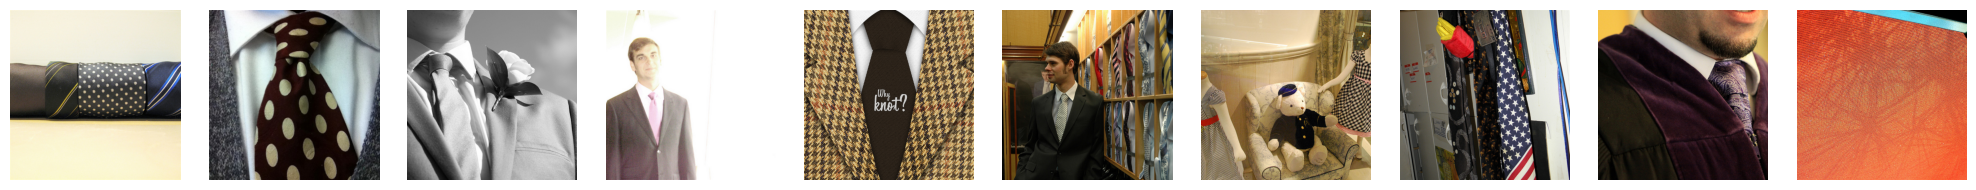

In [116]:
dimension = 'clothing'
subject = 5

dataset = NSDCLIPFeaturesDataset(
    nsd = NaturalScenesDataset(
        root='data/nsd',
        subject=subject,
        partition='train',
    ),
    clip_extractor_type='clip_2_0'
)
shift_vector = np.load(f'dimension_vecs/{dimension}.npy')
sims = 1 - pairwise_distances(dataset.features, shift_vector.reshape(1,-1), metric='cosine')
order = np.argsort(sims[:,0])[::-1]

num = 10
f, axes = plt.subplots(1, num, figsize=(num*2, 2))
for i, ax in enumerate(axes):
    ax.imshow(dataset.nsd[order[i]][0])
    ax.axis('off')
plt.tight_layout()
plt.show()

### Dimension through manipulations

(50, 11, 35)
(50, 11)


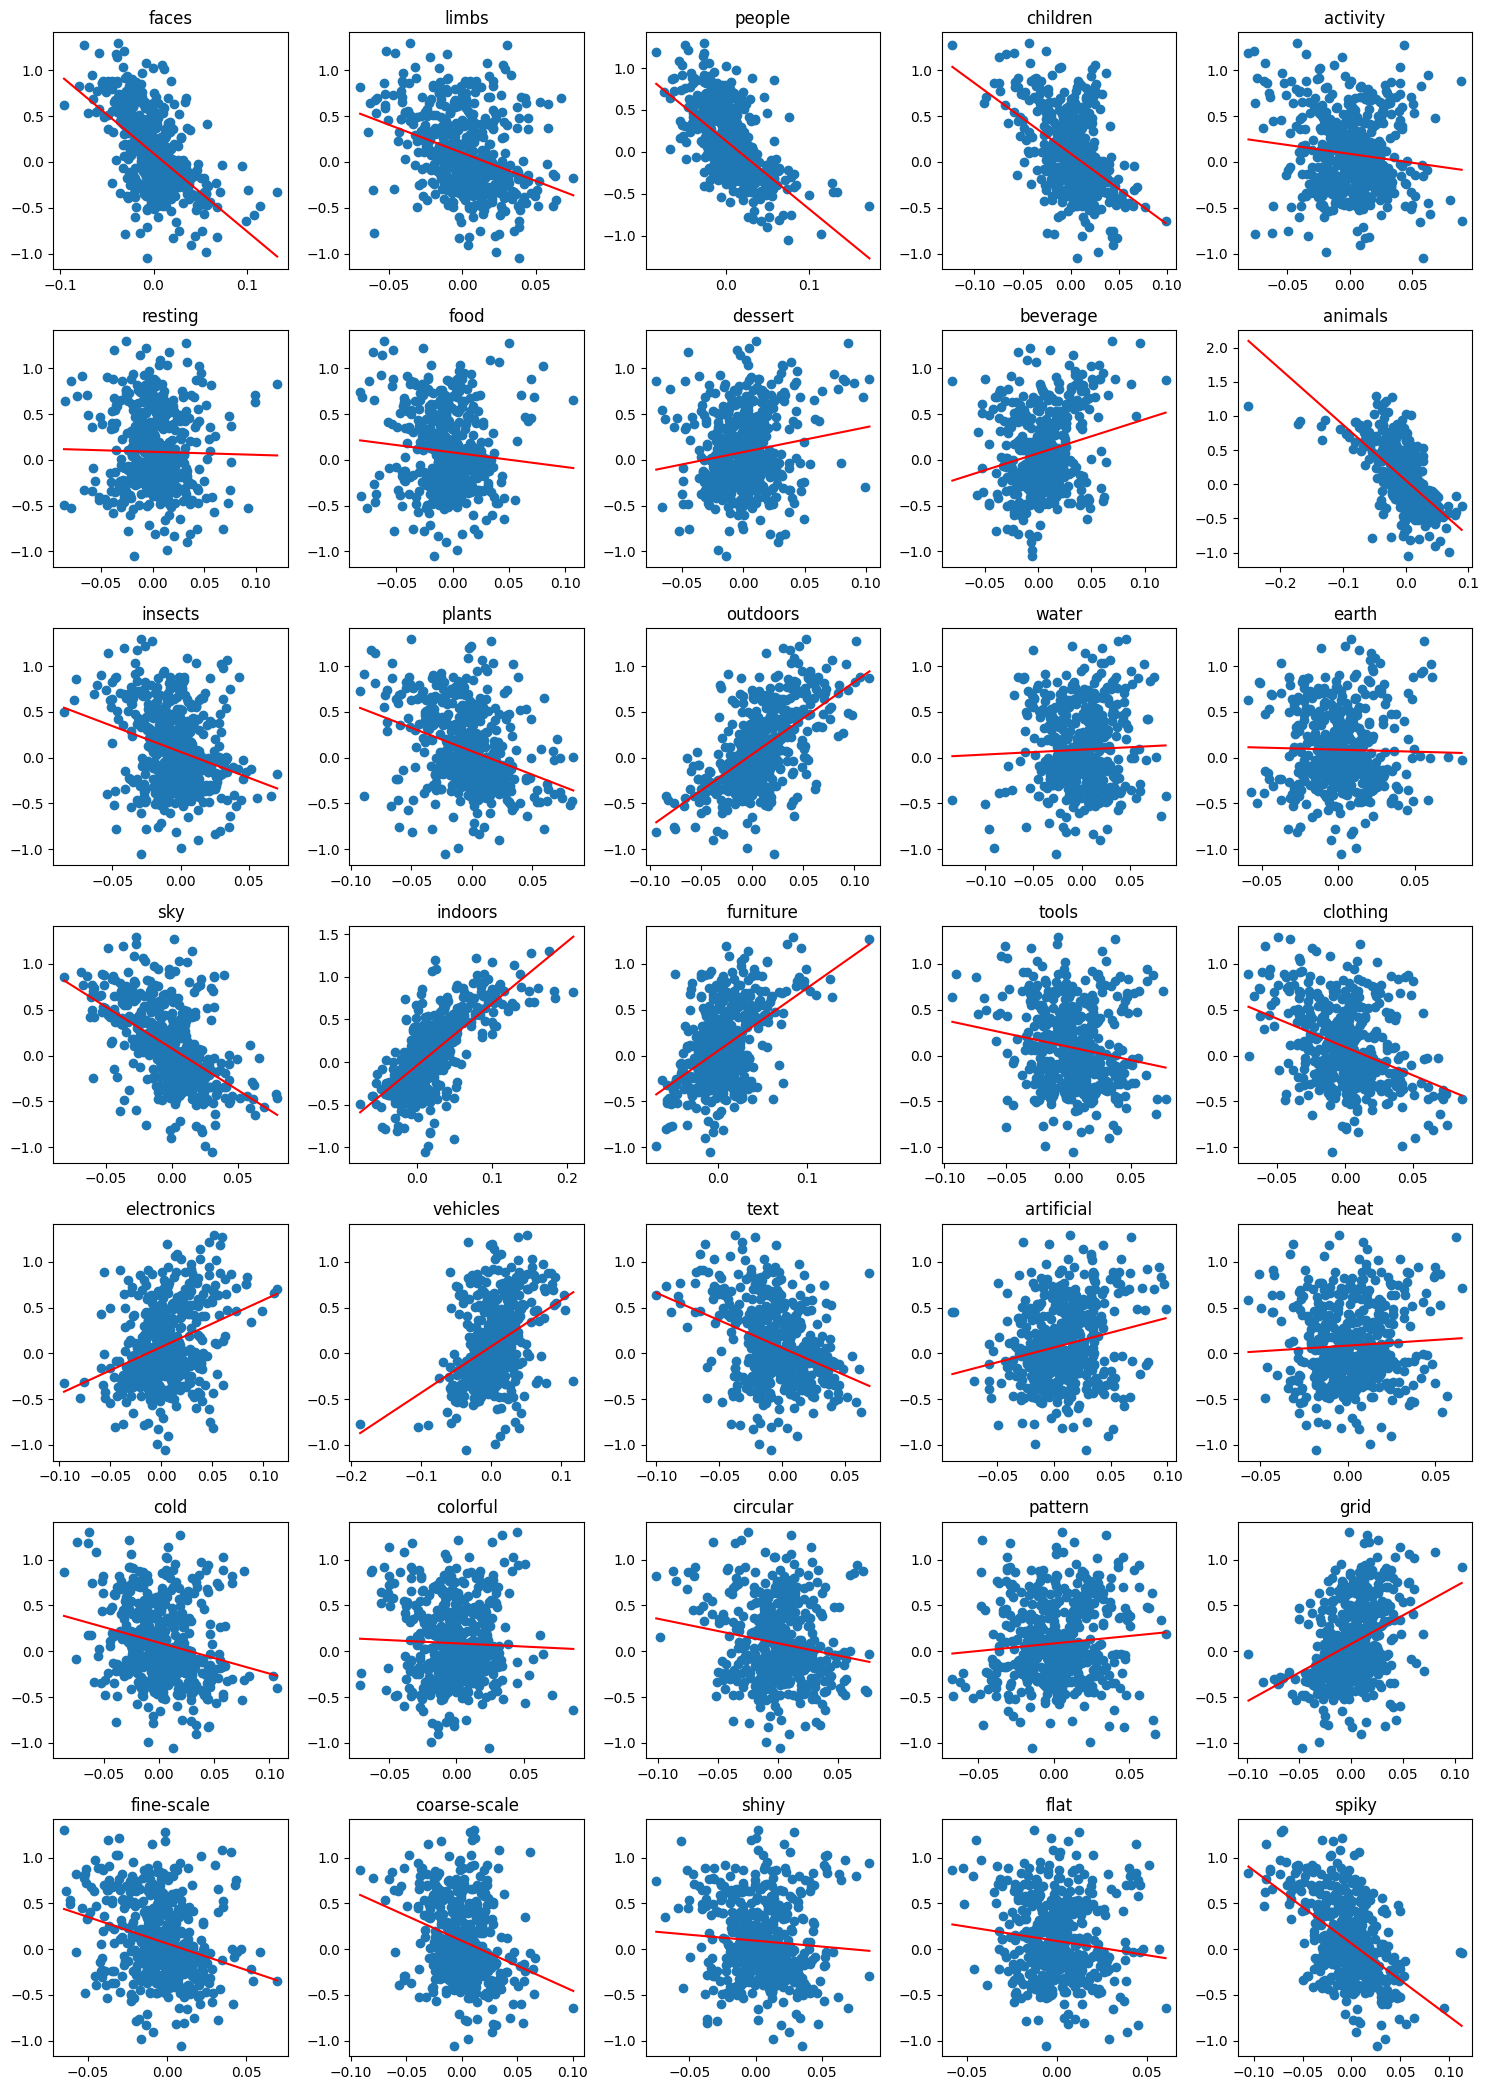

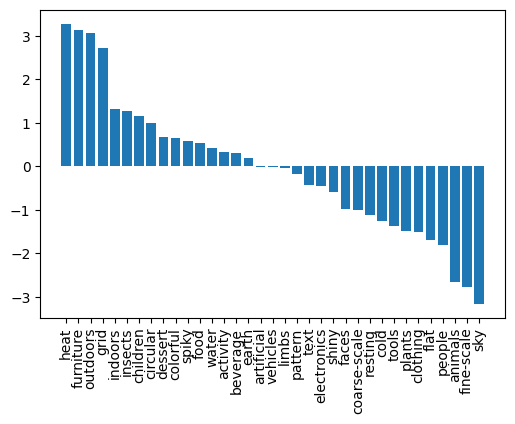

In [172]:
subject = 5
roi = 'PPA'
hemisphere = 'left'

subject_i = subjects.index(subject)
roi_i = rois.index(roi)
hemisphere_i = hemispheres.index(hemisphere)

data = dimension_sims[subject_i, hemisphere_i, roi_i, :, :]
data = (data - data[:, [5]])
print(data.shape)

dino_p = preds_dino[subject_i, hemisphere_i, roi_i, :, hemisphere_i, roi_i]
dino_p = (dino_p - dino_p[:, [5]])
print(dino_p.shape)

f, axes = plt.subplots(7,5, figsize=(15, 21))
for i, dim in enumerate(dimensions):
    x,y = np.unravel_index(i, (7,5))
    axes[x,y].scatter(data.reshape(-1,35)[:,i], dino_p.reshape(-1))
    axes[x,y].plot(np.unique(data.reshape(-1,35)[:,i]), np.poly1d(np.polyfit(data.reshape(-1,35)[:,i], dino_p.reshape(-1), 1))(np.unique(data.reshape(-1,35)[:,i])), color='red')
    axes[x,y].set_title(dimensions[i])
plt.tight_layout()
plt.show()

model = LinearRegression().fit(data.reshape(-1,35), dino_p.reshape(-1))
coeffs = model.coef_
order = np.argsort(coeffs)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(dimensions[order], coeffs[order])
plt.xticks(rotation=90)
plt.show()

### Playground: dimensions

In [9]:
noun_vecs = np.array([np.load(os.path.join(data_dir, f'shift_vectors/nouns/{n}.npy')) for n in nouns])

KeyboardInterrupt: 

In [ ]:
dimension_vecs = []

for dim in tqdm(dimensions):

    df = dimensions_csv[dimensions_csv['dimension'] == dim]
    scores = np.array(df['score'].values)
    scores = (scores - scores.min()) / (scores.max() - scores.min())
    order = np.argsort(scores)

    # OLS closed form solution
    lmbda = 1e+1
    W = noun_vecs.T @ noun_vecs + lmbda * np.eye(noun_vecs.shape[1])
    W = np.linalg.inv(W) @ noun_vecs.T @ scores
    v = W

    dimension_vecs.append(v)

dimension_vecs = np.stack(dimension_vecs)

  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
from datasets.nsd.nsd_clip import NSDCLIPFeaturesDataset
from datasets.nsd.nsd import NaturalScenesDataset
from methods.high_level_attributes.shift_vectors import load_shift_vector_from_nsd

subject = 5
roi = 'OFA'
hemisphere = 'left'

dataset = NSDCLIPFeaturesDataset(
    nsd = NaturalScenesDataset(
        root='data/nsd',
        subject=subject,
        partition='train',
        hemisphere=hemisphere,
        roi=roi,
    ),
    clip_extractor_type='clip_2_0'
)

shift_vector_OFA = load_shift_vector_from_nsd(dataset.nsd, 'data/checkpoints')

subject = 5
roi = 'OPA'
hemisphere = 'left'

dataset = NSDCLIPFeaturesDataset(
    nsd = NaturalScenesDataset(
        root='data/nsd',
        subject=subject,
        partition='train',
        hemisphere=hemisphere,
        roi=roi,
    ),
    clip_extractor_type='clip_2_0'
)

shift_vector_OPA = load_shift_vector_from_nsd(dataset.nsd, 'data/checkpoints')

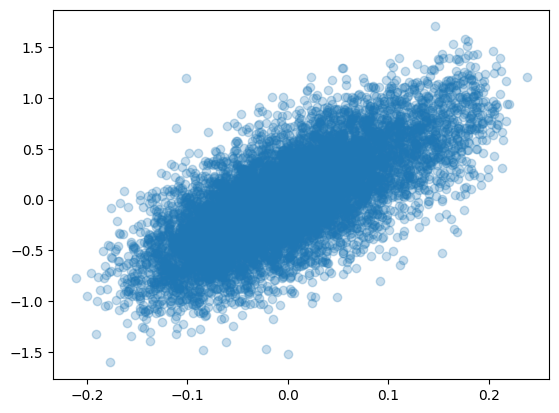

In [ ]:
sims = 1 - pairwise_distances(dataset.features, shift_vector_OPA.reshape(1,-1), metric='cosine')
acts = dataset.nsd.activations.mean(-1).numpy()

plt.scatter(sims, acts, alpha=0.25)
plt.show()

In [ ]:
shift_vector = shift_vector_OFA - shift_vector_OPA
print(1 - pairwise_distances(shift_vector_OFA.reshape(1,-1), shift_vector_OPA.reshape(1,-1), metric='cosine')[0])
print(1 - pairwise_distances(shift_vector.reshape(1,-1), shift_vector_OFA.reshape(1,-1), metric='cosine')[0])
print(1 - pairwise_distances(shift_vector.reshape(1,-1), shift_vector_OPA.reshape(1,-1), metric='cosine')[0])

[-0.12090182]
[0.7486326]
[-0.74863267]


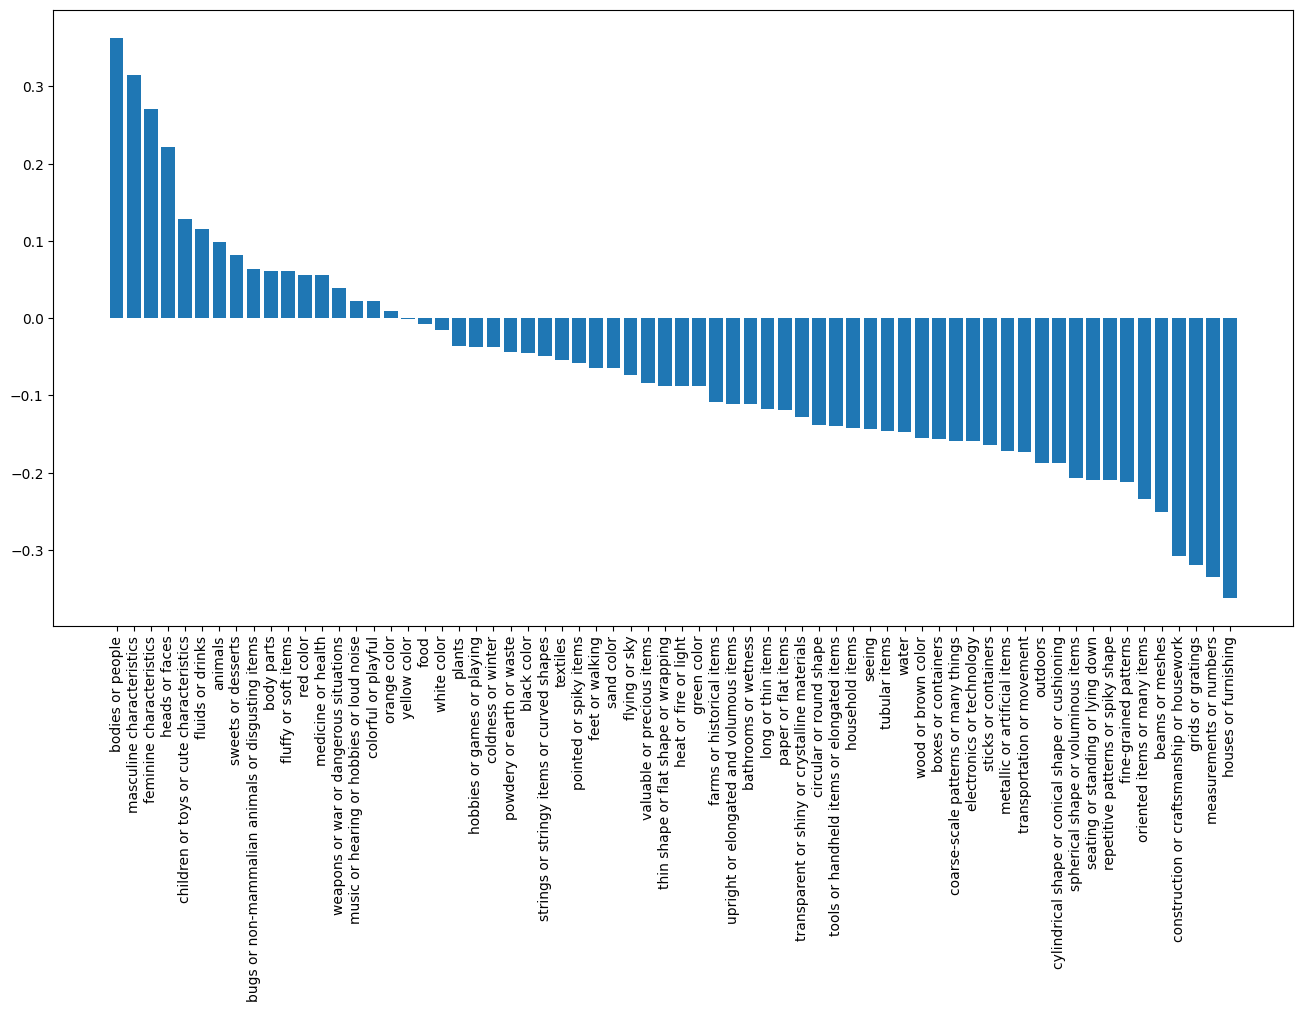

In [ ]:
sims = 1 - pairwise_distances(shift_vector.reshape(1,-1), dimension_vecs, metric='cosine')[0]
sims_OPA = 1 - pairwise_distances(shift_vector_OPA.reshape(1,-1), dimension_vecs, metric='cosine')[0]

diffs = sims - sims_OPA
order = np.argsort(diffs)[::-1]

plt.figure(figsize=(16, 8))
plt.bar(np.array(dimensions)[order], diffs[order])
plt.xticks(rotation=90)
plt.show()

In [ ]:
sims.shape

(1, 66)

In [ ]:
sims = 1 - pairwise_distances(dataset.features, dimension_vecs, metric='cosine')

In [ ]:
for dimension in dimensions:

    print(dimension)

    dim_i = dimensions.index(dimension)
    idxs = np.argsort(sims[:, dim_i])[::-1].copy()
    idxs = idxs[:20]

    f, axes = plt.subplots(1, 20, figsize=(40, 2))
    for i, idx in enumerate(idxs):
        img = dataset[idx][0]
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

### Playground: optimization

In [ ]:
from methods.high_level_attributes.clip_extractor import create_clip_extractor
from datasets.nsd.utils.nsd_utils import (get_roi_indices, parse_rois)
from run_train_encoder import EncoderModule
from datasets.nsd.nsd_clip import NSDCLIPFeaturesDataset
from datasets.nsd.nsd import NaturalScenesDataset
from methods.high_level_attributes.shift_vectors import load_shift_vector_from_nsd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

subject = 5
roi = 'PPA'
hemisphere = 'left'
ckpt_dir = 'data/checkpoints'

In [ ]:
dataset = NSDCLIPFeaturesDataset(
    nsd = NaturalScenesDataset(
        root='data/nsd',
        subject=subject,
        partition='test',
        hemisphere=hemisphere,
        roi=roi,
    ),
    clip_extractor_type='clip_2_0'
)

shift_vector = load_shift_vector_from_nsd(dataset.nsd, ckpt_dir)

In [ ]:
roi_names, roi_classes = parse_rois([roi])
roi_indices = get_roi_indices(os.path.join('data/NSD/', f"subj{subject:02d}"), roi_names, roi_classes, hemisphere)

if hemisphere == 'left':
    ckpt_path = os.path.join(ckpt_dir, 'clip_linear', f'0{subject}_all_l_all_0')
else:
    ckpt_path = os.path.join(ckpt_dir, 'clip_linear', f'0{subject}_all_r_all_0')
ckpt_path = os.path.join(ckpt_path, sorted(list(os.listdir(ckpt_path)))[-1])

encoder = EncoderModule.load_from_checkpoint(ckpt_path).to(device).eval()

/home/diego/miniconda3/envs/braindive/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.0


In [ ]:
preds = []
for i in range(len(dataset)):
    feats = torch.tensor(dataset[i][1]).to(device)
    pred = encoder(feats).squeeze(0).detach().cpu().numpy()[roi_indices].mean(-1)
    preds.append(pred)
preds = np.array(preds)

In [ ]:
sims = 1 - pairwise_distances(dataset.features, shift_vector.reshape(1,-1), metric='cosine')[:,0]

(872,)

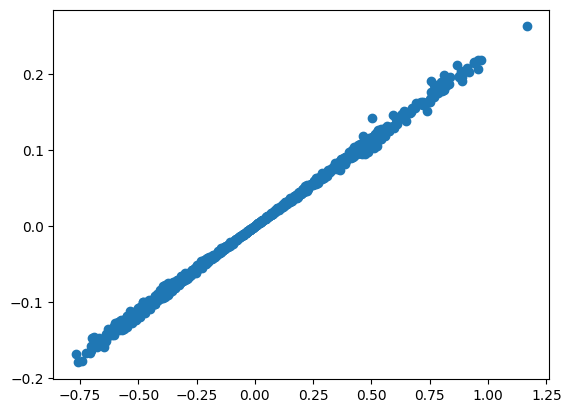

In [ ]:
plt.scatter(preds, sims)
plt.show()